# EOLES_elecRES in Julia: simplified

This notebook is a simplified version of [EOLES_elecRES_Julia.ipynb](EOLES_elecRES_Julia.ipynb):
- no operating reserverve
- no biogas and river generation
- only two storage types: power-to-gas-to-power and battery
  - Gas could be H2 in this model
  - no Pumpep hydro (PHS)

In [1]:
using CSV, DataFrames, PyPlot
using JuMP
using Clp

In [2]:
const DAArray = JuMP.Containers.DenseAxisArray;

## Model data

### Sets

#### hours and months

In [3]:
h = 0:8759

0:8759

In [4]:
first_h = h .== h[1] # BitArray, with first element true
last_h = h .== h[end]; # BitArray, with last element true

In [5]:
m = [:jan, :feb, :mar, :apr, :may, :jun, :jul, :aug, :sep, :oct, :nov, :dec]

12-element Vector{Symbol}:
 :jan
 :feb
 :mar
 :apr
 :may
 :jun
 :jul
 :aug
 :sep
 :oct
 :nov
 :dec

#### technology sets

All technologies

In [6]:
tec = [:offshore, :onshore, :pv, :gas, :battery, :methanation] 

6-element Vector{Symbol}:
 :offshore
 :onshore
 :pv
 :gas
 :battery
 :methanation

Subsets of `tec`

In [7]:
# power plants
gen = [:offshore, :onshore, :pv, :gas]
# variable tecs
vre = [:offshore, :onshore, :pv]
# non-combustible generation
ncomb = [:offshore, :onshore, :pv, :battery]
# combustible generation techs
# Remark: in equations, its defined that 'gas' generation 
# is the sum of the generations from 'comb' elements
comb = [:methanation]
# storage technologies
str = [:battery, :methanation]
# technologies for upward FRR
frr = [:battery, :gas];

Check that subsets are indeed subsets (i.e. performing the automatic [domain checking](https://www.gams.com/latest/docs/UG_SetDefinition.html#UG_SetDefinition_DomainChecking) of GAMS)

In [8]:
for tec_subset in [gen, vre, ncomb, comb, str, frr]
    @assert issubset(tec_subset, tec) "should be a subset of tec!"
end

### Parameters

Original GAMS definition for months:
```
parameter month(h)  /0*743 1, 744*1439 2, 1440*2183 3, 2184*2903 4
                    2904*3647 5, 3648*4367 6, 4368*5111 7, 5112*5855 8
                    5856*6575 9, 6576*7319 10, 7320*8039 11, 8040*8759 12/
```

observe that February has 29 days, which is compensated by December having only 30:

In [9]:
(1439 - 744 +1)/24, (8759 - 8040 +1)/24

(29.0, 30.0)

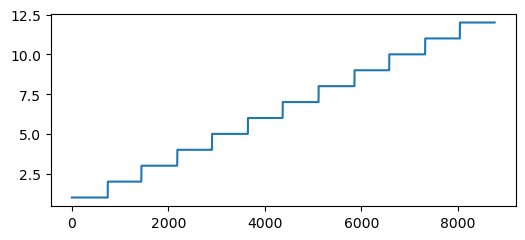

In [10]:
month = [
     repeat([1], 31*24);  repeat([2], 29*24);  repeat([3], 31*24);  repeat([4], 30*24);
     repeat([5], 31*24);  repeat([6], 30*24);  repeat([7], 31*24);  repeat([8], 31*24);
     repeat([9], 30*24); repeat([10], 31*24); repeat([11], 30*24); repeat([12], 30*24)
]

figure(figsize=(6,2.5))
plot(h, month);

Convert `month` values from Integers to corresponding Symbols

In [11]:
month_sym = [m[mk] for mk in month];

Helper to read CSV files

In [12]:
"""
    readdelim(source, dims...; default_value=0.)

Read the CSV file `source` formatted as for the GAMS' `\$onDelim`/`\$offDelim` instructions
(i.e. a long, database-like format).
The vectors of each dimension of the output are specified with `dims`.

Remark: Strings are lowercased and converted to Symbols
"""
function readdelim(source, dims...; default_value=0.)
    print("reading $source...")
    # create reverse maps from value  to index for each dim vector
    ndim = length(dims)
    dim_maps = []
    for dim in dims
        dim_map = Dict((v,i) for (i,v) in enumerate(dim))
        push!(dim_maps, dim_map)
    end
    
    # load datafile
    df = DataFrame(CSV.File(source, header=false))
    ncol = size(df,2)
    @assert ncol == (ndim+1) "$(ndim+1) columns exected in $source, got $(ncol)"
    
    # Create array and fill with data
    a = zeros((length(dim) for dim in dims)...)
    fill!(a, default_value)
    
    to_symb(a) = if (typeof(a) <: AbstractString) Symbol(lowercase(a)) else a end
    
    for row in eachrow(df)
        if ndim == 1
            i = dim_maps[1][to_symb(row[1])]
            a[i] = row[2]
        elseif ndim == 2
            i = dim_maps[1][to_symb(row[1])]
            j = dim_maps[2][to_symb(row[2])]
            a[i,j] = row[3]
        else
            throw(ArgumentError("only 2 dims supported, got $(ndim)!"))
        end
    end
    # Convert to JuMP.Containers.DenseAxisArray for easier indexing
    return JuMP.Containers.DenseAxisArray(a, dims...)
end

readdelim

parameter `load_factor(vre,h)` 'Production profiles of VRE'

from file `inputs/vre_profiles2006.csv`

In [13]:
load_factor = readdelim("inputs/vre_profiles2006.csv", vre, h; default_value=0.)

reading inputs/vre_profiles2006.csv...

2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, [:offshore, :onshore, :pv]
    Dimension 2, 0:8759
And data, a 3×8760 Matrix{Float64}:
 0.865143  0.88     0.88      0.873429  …  0.990286  0.991     0.988143
 0.511702  0.52791  0.537973  0.541571     0.826158  0.825222  0.818481
 0.0       0.0      0.0       0.0          0.0       0.0       0.0

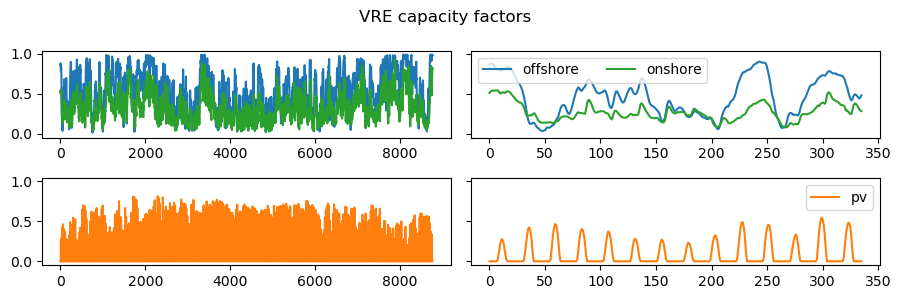

In [14]:
z = 1:24*14 # zoom
fig, ax = subplots(2,2, figsize=(9, 3), sharey=true)

# Wind
ax[1,1].plot(h, load_factor[:offshore,:].data, label=vre[1])
ax[1,1].plot(h, load_factor[:onshore,:].data, "C2", label=vre[2])
ax[1,2].plot(h[z], load_factor[:offshore,:].data[z], label=vre[1])
ax[1,2].plot(h[z], load_factor[:onshore,:].data[z], "C2", label=vre[2])
ax[1,2].legend(ncol=2)

# PV
ax[2,1].plot(h, load_factor[:pv,:].data, "C1", label=vre[3])
ax[2,2].plot(h[z], load_factor[:pv,:].data[z], "C1", label=vre[3])
ax[2,2].legend()

fig.suptitle("VRE capacity factors")
fig.tight_layout();

Parameter `demand(h)` 'demand profile in each hour in GW'

from file `inputs/demand2050_ademe.csv`

In [15]:
demand = readdelim("inputs/demand2050_ademe.csv", h);

reading inputs/demand2050_ademe.csv...

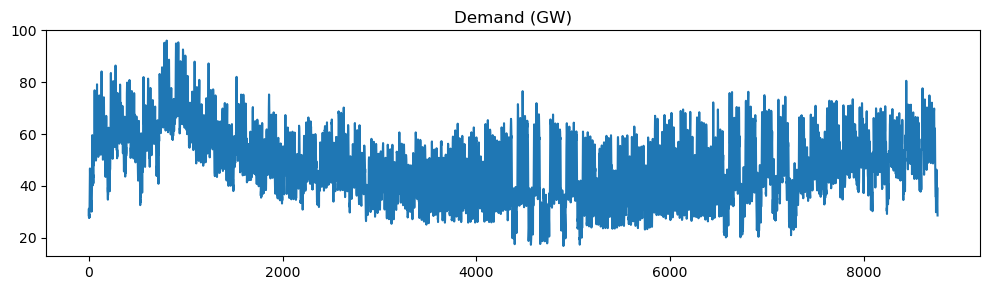

In [16]:
figure(figsize=(10, 3))
plot(h, demand.data)
title("Demand (GW)")
tight_layout()

parameter `epsilon(vre)` 'additional FRR requirement for variable renewable energies because of forecast errors'

from `inputs/reserve_requirements.csv`

In [17]:
epsilon = readdelim("inputs/reserve_requirements.csv", vre)
[vre epsilon]

reading inputs/reserve_requirements.csv...

3×2 Matrix{Any}:
 :offshore  0.027
 :onshore   0.027
 :pv        0.038

parameter `capa_max(tec)` 'maximum capacities of the technologies in GW'

from `inputs/max_capas.csv`

Remarks:
- again "gas" is missing from the file
- but eventually, only the values for offshore, onshore and pv is used to contraint the `CAPA` variable.
- "phs" max capa is set in `pump_capa=9.3` (coherent with file)
- "lake" max capacity is set to 13 (coherent with file)
- "river" capacity is *fixed* to `capa_ex('river')` (7.5, which is coherent with file)

In [18]:
capa_max = readdelim("inputs_simplified/max_capas.csv", tec)
[tec capa_max]

reading inputs_simplified/max_capas.csv...

6×2 Matrix{Any}:
 :offshore      20.0
 :onshore      120.0
 :pv           218.0
 :gas            0.0
 :battery      100.0
 :methanation  100.0

parameter `capex(tec)` 'annualized power capex cost in M€/GW/year'

from `inputs/annuities.csv`

In [19]:
capex = readdelim("inputs_simplified/annuities.csv", tec);

reading inputs_simplified/annuities.csv...

parameter `capex_en(str)` 'annualized energy capex cost of storage technologies in M€/GWh/year'

from `inputs/str_annuities.csv`

In [20]:
capex_en = readdelim("inputs_simplified/str_annuities.csv", str)
[str capex_en]

reading inputs_simplified/str_annuities.csv...

2×2 Matrix{Any}:
 :battery      10.634
 :methanation   0.0

parameter `fOM(tec)` 'annualized fixed operation and maintenance costs M€/GW/year'

from `inputs/fO&M.csv`

In [21]:
fOM = readdelim("inputs_simplified/fO&M.csv", tec);

reading inputs_simplified/fO&M.csv...

Total fixed costs:

In [22]:
fixed_costs = DAArray(capex.data + fOM.data, tec) # 'yearly fixed cost of each tec in M€/GW/year'
[tec capex fOM fixed_costs]

6×4 Matrix{Any}:
 :offshore     144.368   47.0318   191.4
 :onshore       77.6621  34.5477   112.21
 :pv            30.0052   9.22619   39.2314
 :gas           33.7653  16.5       50.2653
 :battery       14.8876   1.96      16.8476
 :methanation    0.0      0.0        0.0

parameter `vOM(tec)` 'Variable operation and maintenance costs in M€/GWh'

from `inputs/vO&M.csv`

In [23]:
vOM = readdelim("inputs_simplified/vO&M.csv", tec)
[tec vOM]

reading inputs_simplified/vO&M.csv...

6×2 Matrix{Any}:
 :offshore     0.0
 :onshore      0.0
 :pv           0.0
 :gas          0.0
 :battery      0.0021
 :methanation  0.005444

parameter `s_capex(str)` 'charging related annuity of storage in M€/GW/year' /PHS 0, battery 0, methanation 84.16086/;

*Remark: this corresponds with the fact that capex[:methanation] is 0*

In [24]:
s_capex = DAArray([0., 84.16086], str)
[str s_capex]

2×2 Matrix{Any}:
 :battery       0.0
 :methanation  84.1609

parameter `s_opex(str)`    'charging related fOM of storage in M€/GW/year'   /PHS 0, battery 0, methanation 59.25/;

In [25]:
s_opex = DAArray([0., 59.25], str)
[str s_opex]

2×2 Matrix{Any}:
 :battery       0.0
 :methanation  59.25

Charging/discharging efficiency

- parameter `eta_in(str)` 'charging efficiency of storage technologies' /PHS 0.95, battery 0.9, methanation 0.59/;
- parameter `eta_out(str)` 'discharging efficiency of storage technolgoies' /PHS 0.9, battery 0.95, methanation 0.45/;

In [26]:
eta_in  = DAArray([0.90, 0.59], str)
eta_out = DAArray([0.95, 0.45], str)
[str eta_in eta_out]

2×3 Matrix{Any}:
 :battery      0.9   0.95
 :methanation  0.59  0.45

Scalar parameters

In [27]:
load_uncertainty = 0.01 # uncertainty coefficient for hourly demand
delta = 0.1; # load variation factor

## Model variables and equations

### LP Solver choice

See e.g. for solve options:
- [Clp](https://github.com/jump-dev/Clp.jl): `PrimalTolerance`, `DualTolerance` (although I didn't see their effect), `Algorithm` (not tested)
- [HiGHS](https://github.com/jump-dev/HiGHS.jl)

In [28]:
RES_FR = Model(Clp.Optimizer)
#RES_FR = Model(HiGHS.Optimizer)

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Clp

### Variables

See [§Variable Attributes](https://www.gams.com/latest/docs/UG_Variables.html#UG_Variables_VariableAttributes) for `.up`, `.lo`, `.fx` and `.l`

See [§Styles for Variable Declaration](https://www.gams.com/latest/docs/UG_Variables.html#UG_Variables_StylesForVariableDeclaration) for the fact it's possible to redeclare the type of a variable. E.g. here to state it's positive

```
variables        GENE(tec,h)     'hourly energy generation in TWh' (⚠ in fact GW)
                 CAPA(tec)       'overal yearly installed capacity in GW'
                 STORAGE(str,h)  'hourly electricity input of battery storage GW'
                 S(str)          'charging power capacity of each storage technology'
                 STORED(str,h)   'energy stored in each storage technology in GWh'
                 CAPACITY(str)   'energy volume of storage technologies in GWh'
                 RSV(frr,h)      'required upward frequency restoration reserve in GW'
                 COST            'final investment cost in b€'

positive variables GENE(tec,h),CAPA(tec),STORAGE(str,h), S(str),STORED(str,h),CAPACITY(str),RSV(frr,h);
```

In [29]:
@variable(RES_FR, GENE[tec,h] >= 0)    # hourly energy generation in GW
@variable(RES_FR, CAPA[tec] >= 0)      # overal yearly installed capacity in GW
@variable(RES_FR, STORAGE[str,h] >= 0) # hourly electricity input of battery storage GW
@variable(RES_FR, S[str] >= 0)         # charging power capacity of each storage technology. Remark S(str) is constrainted <= CAPA(str);
@variable(RES_FR, STORED[str,h] >= 0)  # energy stored in each storage technology in GWh
@variable(RES_FR, CAPACITY[str] >= 0)  # energy volume of storage technologies in GWh

1-dimensional DenseAxisArray{VariableRef,1,...} with index sets:
    Dimension 1, [:battery, :methanation]
And data, a 2-element Vector{VariableRef}:
 CAPACITY[battery]
 CAPACITY[methanation]

In [30]:
@variable(RES_FR, COST);

Maximal capacities:

In [31]:
@constraint(RES_FR, CAPA[:offshore] <= capa_max[:offshore])
@constraint(RES_FR, CAPA[:onshore] <= capa_max[:onshore])
@constraint(RES_FR, CAPA[:pv] <= capa_max[:pv]);

### Equations (i.e. constraints)

`gene_vre(vre,h)` variables renewable profiles generation:

In [32]:
@constraint(RES_FR, gene_vre[vrek=vre, hk=h],
            GENE[vrek,hk] == CAPA[vrek]*load_factor[vrek,hk]);

Equation `gene_capa(tec,h)` capacity and generation relation for technologies:

In [33]:
@constraint(RES_FR, gene_capa[teck=tec, hk=h],
            CAPA[teck] >= GENE[teck,hk]);

`combustion(h)` the relationship of combustible technologies (in this simplified model 'gas' = 'methanation', since 'biogas' is absent):

In [34]:
@constraint(RES_FR, combustion[hk=h],
            GENE[:gas,hk] == sum(GENE[combk,hk] for combk in comb));

In [35]:
combustion[0]

combustion[0] : GENE[gas,0] - GENE[methanation,0] = 0.0

`storing(h,h+1,str)` the definition of stored energy in the storage options;

    STORED(str,h+1) =e= STORED(str,h) + STORAGE(str,h)*eta_in(str) - GENE(str,h)/eta_out(str);

Remark: see GAMS UG [§Lag and Lead Operators](https://www.gams.com/latest/docs/UG_OrderedSets.html#UG_OrderedSets_LagLeadOperators) for the meaning of `h+1`.
However, it's not clear to me why the equation is declared on both `h` and `h+1`. 

In [36]:
@constraint(RES_FR, storing[strk=str, hk=h[1:end-1]],
            STORED[strk,hk+1] == STORED[strk,hk] + 
            STORAGE[strk,hk]*eta_in[strk] - GENE[strk,hk]/eta_out[strk]);

In [37]:
storing[:battery,1]

storing[battery,1] : 1.0526315789473684 GENE[battery,1] - 0.9 STORAGE[battery,1] - STORED[battery,1] + STORED[battery,2] = 0.0

`storage_const(str,first,last)` storage in the first hour is equal to the storage in the last hour:

    STORED(str,first) =e= STORED(str,last)+STORAGE(str,last)*eta_in(str)-GENE(str,last)/eta_out(str);

In [38]:
@constraint(RES_FR, storage_const[strk=str],
            STORED[strk,h[1]] == STORED[strk,h[end]] + 
            STORAGE[strk,h[end]]*eta_in[strk] - GENE[strk,h[end]]/eta_out[strk]);

In [39]:
storage_const[:battery]

storage_const[battery] : 1.0526315789473684 GENE[battery,8759] - 0.9 STORAGE[battery,8759] + STORED[battery,0] - STORED[battery,8759] = 0.0

`stored_cap(str,h)` maximum energy that is stored in storage units:

In [40]:
@constraint(RES_FR, stored_cap[strk=str, hk=h],
            STORED[strk,hk] <= CAPACITY[strk]);

`storage_capa1(str,h)` the capacity with hourly charging relationship of storage:

In [41]:
@constraint(RES_FR, storage_capa1[strk=str, hk=h],
            S[strk] >= STORAGE[strk,hk]);

`storage_capa2(str)` storage power limit:

In [42]:
@constraint(RES_FR, storage_capa2[strk=str],
            S[strk] <= CAPA[strk]);

`adequacy(h)` supply/demand relation:

In [43]:
@constraint(RES_FR, adequacy[hk=h],
            sum(GENE[ncombk,hk] for ncombk in ncomb) + GENE[:gas,hk] >=
            demand[hk] + sum(STORAGE[:,hk]));

In [44]:
adequacy[3]

adequacy[3] : GENE[offshore,3] + GENE[onshore,3] + GENE[pv,3] + GENE[gas,3] + GENE[battery,3] - STORAGE[battery,3] - STORAGE[methanation,3] ≥ 27.9874884

`obj` the final objective function which is `COST`

    COST                    =e=     (
        sum(tec,(CAPA(tec)-capa_ex(tec))*capex(tec))+ 
        sum(str,CAPACITY(str)*capex_en(str))+
        sum(tec,(CAPA(tec)*fOM(tec)))+ 
        sum(str,S(str)*(s_capex(str)+s_opex(str))) + 
        sum((tec,h),GENE(tec,h)*vOM(tec))
        )/1000;

In [45]:
@constraint(RES_FR, cost,
            COST == (
            sum( CAPA[teck]*capex[teck] for teck in tec) +
            sum( CAPACITY[strk]*capex_en[strk] for strk in str) +
            sum( CAPA[teck]*fOM[teck] for teck in tec) +
            sum( S[strk]*(s_capex[strk]+s_opex[strk]) for strk in str) +
            sum( GENE[teck,hk]*vOM[teck] for teck in tec for hk in h)
            )/1000 );

In [46]:
@objective(RES_FR, Min, COST);

### Solve

- 80 s with Clp (on notebook with Intel i7-1165G7)

In [47]:
@time optimize!(RES_FR);

Coin0506I Presolve 70080 (-78846) rows, 52567 (-35044) columns and 214968 (-175215) elements
Clp0006I 0  Obj 0 Primal inf 2940818.2 (8760) Dual inf 1.0113253e+16 (17523)
Clp0006I 575  Obj 59.340437 Primal inf 15733.661 (338) Dual inf 1.5350288e+14 (808)
Clp0006I 1150  Obj 61.954371 Primal inf 12332.702 (311) Dual inf 15688119 (1171)
Clp0006I 1725  Obj 63.804063 Primal inf 9229.7315 (229) Dual inf 10272420 (927)
Clp0006I 2300  Obj 75.749046 Primal inf 4640.9368 (78) Dual inf 2232939.8 (443)
Clp0006I 2875  Obj 75.822111 Primal inf 3315.0092 (147) Dual inf 5055103.5 (948)
Clp0006I 3450  Obj 72.204651 Primal inf 2299.949 (120) Dual inf 6335052.2 (715)
Clp0006I 4025  Obj 71.705583 Primal inf 1925.7553 (123) Dual inf 1800305.2 (1025)
Clp0006I 4600  Obj 73.798268 Primal inf 1239.5883 (69) Dual inf 2872892.1 (1005)
Clp0006I 5175  Obj 75.150001 Primal inf 903.6631 (28) Dual inf 2492271.6 (1031)
Clp0006I 5750  Obj 75.807876 Primal inf 780.89537 (29) Dual inf 1826634 (1091)
Clp0006I 6325  Obj 74.

In [48]:
termination_status(RES_FR)

OPTIMAL::TerminationStatusCode = 1

Increase solver precision (quite fast: there is probably a warm start)

In [49]:
set_optimizer_attribute(RES_FR, "PrimalTolerance", 1e-10)
set_optimizer_attribute(RES_FR, "DualTolerance", 1e-10)
optimize!(RES_FR);

Coin0506I Presolve 70080 (-78846) rows, 52567 (-35044) columns and 214968 (-175215) elements
Clp0006I 0  Obj 28.149484
Clp0000I Optimal - objective value 28.149484
Coin0511I After Postsolve, objective 28.149484, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 28.14948421 - 0 iterations time 4.832, Presolve 4.70


## Results

Cost: (for reference 21.832 G€ for the full EOLES_elecRES model)

In [50]:
value(COST) # Clp

28.149484210059413

Installed capacities:

In [51]:
CAPA_res = value.(CAPA)
[tec CAPA_res] # GW

6×2 Matrix{Any}:
 :offshore       4.76337
 :onshore      111.265
 :pv           160.093
 :gas           47.1571
 :battery       37.8616
 :methanation   47.1571

Storage:

Energy capacity along max charging power and discharging (Generation) power:

In [52]:
CAPACITY_res = value.(CAPACITY) # GWh
S_res = value.(S) # GW
[str CAPACITY_res S_res CAPA_res[str]]

2×4 Matrix{Any}:
 :battery        245.368  37.8616  37.8616
 :methanation  38951.0    18.2502  47.1571

Total generation by tec:

```
V)Overall yearly energy generation of each technology

Offshore                       59.37 TWh
onsore                        225.83 TWh
PV                            173.16 TWh
run of river                   29.19 TWh
lake                           15.82 TWh
biogas                         15.00 TWh
gas                            25.05 TWh
phs                            20.93 TWh
battery                        13.34 TWh
Methanation                    10.05 TWh
```

In [53]:
GENE_res = value.(GENE)
# 'Overall yearly energy generated by the technology in TWh';
gene_tec = DAArray(dropdims(sum(GENE_res.data,dims=2),dims=2)/1000, tec);
print("Generation (TWh/y, % of demand):")
[tec gene_tec 100e3*gene_tec/sum(demand)]

Generation (TWh/y, % of demand):

6×3 Matrix{Any}:
 :offshore      21.9241   5.19065
 :onshore      316.489   74.9304
 :pv           227.652   53.8977
 :gas           23.7208   5.61602
 :battery       51.4993  12.1927
 :methanation   23.7208   5.61602

capacity factors:
- cf are unchanged for wind and PV
- for gas, the cf is at 5.7% down from 9% for the full EOLES model (perhaps due to the removal of biogas)

In [54]:
# load factor of generation technologies
cf = DAArray([gene_tec[genk]*1000/(8760*CAPA_res[genk]) for genk in gen], gen)
[gen cf]

4×2 Matrix{Any}:
 :offshore  0.525416
 :onshore   0.324709
 :pv        0.162328
 :gas       0.0574219

In [55]:
STORED_res = value.(STORED)
STORAGE_res = value.(STORAGE);

Prices:

In [56]:
spot_price = 1000000*dual.(adequacy);

In [57]:
marginal_cost = sum(spot_price)/8760;
marginal_cost # €/MWh (up from 56.477 for full model)

59.399530015919275

Check adequacy constraint:

In [58]:
ΔGENE_gas = GENE_res[:gas,:] - GENE_res[:methanation,:]
minimum(ΔGENE_gas), maximum(ΔGENE_gas)

(0.0, 0.0)

In [59]:
ΣGENE = sum(GENE_res[ncombk,:] for ncombk in ncomb) + GENE_res[:gas,:]
ΣSTORAGE = sum(STORAGE_res[strk,:] for strk in str)
ΔADEQ = ΣGENE - demand - ΣSTORAGE
minimum(ΔADEQ), maximum(ΔADEQ) # 132 GW maximum power spillage/curtailment

(-4.263256414560601e-14, 132.36642290491426)

In [60]:
sum(ΔADEQ) # GWh of spillage/curtailment (up from 62564 for full model)

69330.65615991718

### Plots

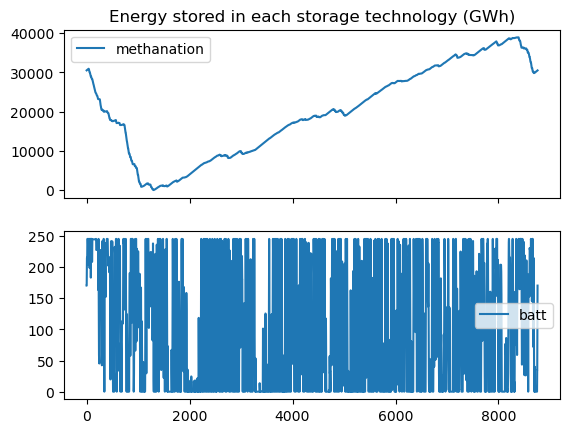

In [61]:
fig, ax = plt.subplots(2,1, sharex=true)
ax[1].set_title("Energy stored in each storage technology (GWh)")
ax[1].plot(h, STORED_res[:methanation,:].data', label="methanation")
ax[1].legend()

ax[2].plot(h, STORED_res[:battery,:].data', label="batt")
ax[2].legend();

Spot price: 
there is a huge peak in February (longer than in full model)

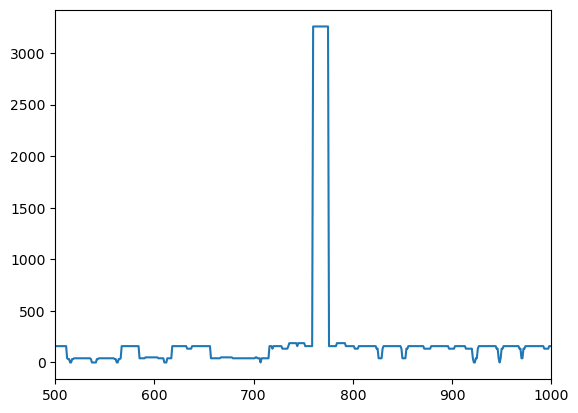

(500.0, 1000.0)

In [62]:
plot(h,spot_price.data)
xlim(500, 1000)

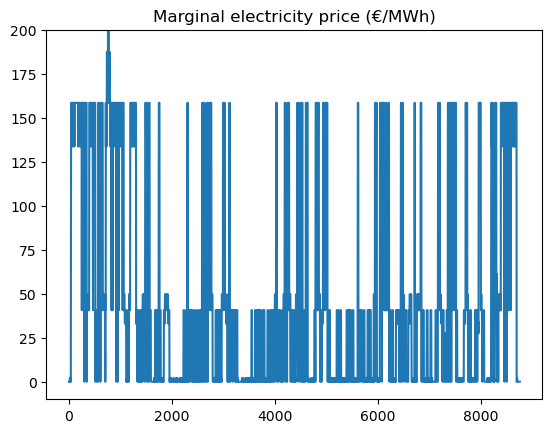

In [63]:
plot(h,spot_price.data)
ylim(-10, 200)
title("Marginal electricity price (€/MWh)");

### Write results to file

Sum of VRE power:

In [64]:
GENE_vre = sum(GENE_res[vrek,:] for vrek in vre).data;

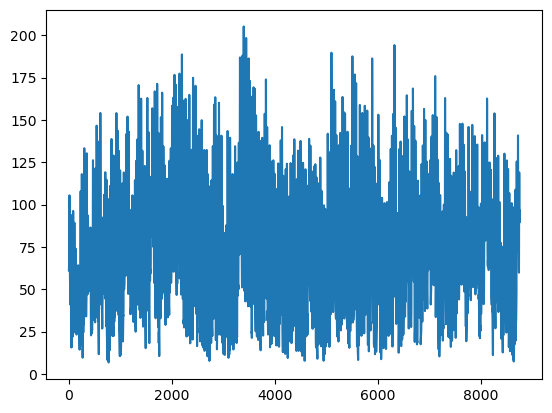

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fce2e462760>

In [65]:
plot(h, GENE_vre)

In [76]:
P_bat = GENE_res[:battery,:].data;
P_bat_sto = STORAGE_res[:battery,:].data;
P_gas = GENE_res[:gas,:].data;
P_gas_sto = STORAGE_res[:methanation,:].data;

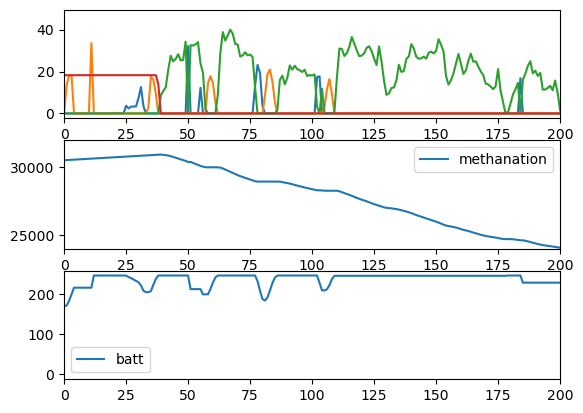

(0.0, 200.0)

In [90]:
subplot(3,1,1)
plot(h,P_bat)
plot(h,P_bat_sto)
plot(h,P_gas)
plot(h,P_gas_sto)

plt.xlim(0, 200)

subplot(3,1,2)
plot(h, STORED_res[:methanation,:].data', label="methanation")
legend();
plt.xlim(0, 200)
plt.ylim(24000, 32000)

subplot(3,1,3)
plot(h, STORED_res[:battery,:].data', label="batt")
legend();
plt.xlim(0, 200)


In [94]:
df = DataFrame(Pdemand=demand.data, Pvre=GENE_vre,
    Pbattery=P_bat-P_bat_sto, Pgas=P_gas-P_gas_sto,
    Ebattery=STORED_res[:battery,:].data,
    Egas=STORED_res[:methanation,:].data
)

Row,Pdemand,Pvre,Pbattery,Pgas,Ebattery,Egas
,Float64,Float64,Float64,Float64,Float64,Float64
1,28.69,61.0557,0.0,-18.2502,170.377,30519.9
2,31.2085,62.9299,-13.4712,-18.2502,170.377,30530.7
3,27.6996,64.0495,-18.0997,-18.2502,182.501,30541.4
4,27.9875,64.4185,-18.1808,-18.2502,198.791,30552.2
5,28.1627,64.0012,0.0,-18.2502,215.154,30563.0
6,28.0214,64.1895,0.0,-18.2502,215.154,30573.7
7,29.0016,64.3152,0.0,-18.2502,215.154,30584.5
8,27.7817,65.0584,0.0,-18.2502,215.154,30595.3
9,31.1354,73.4375,0.0,-18.2502,215.154,30606.1


In [95]:
CSV.write("EOLES_simplified_timeseries.csv", df)

"EOLES_simplified_timeseries.csv"

In [98]:
CAPA_res.data

6-element Vector{Float64}:
   4.763374604967674
 111.26531929026874
 160.09311486658052
  47.157146985463726
  37.86158316601808
  47.15714698546374

In [107]:
df_Pgen = DataFrame(techno=CAPA_res.axes[1],Pmax=CAPA_res.data)

Row,techno,Pmax
,Symbol,Float64
1,offshore,4.76337
2,onshore,111.265
3,pv,160.093
4,gas,47.1571
5,battery,37.8616
6,methanation,47.1571


In [109]:
df_EPsto = DataFrame(storage_techno=str, Emax=CAPACITY_res.data, Pmax=S_res.data)

Row,storage_techno,Emax,Pmax
,Symbol,Float64,Float64
1,battery,245.368,37.8616
2,methanation,38951.0,18.2502


In [110]:
CSV.write("EOLES_simplified_Pgen.csv", df_Pgen)
CSV.write("EOLES_simplified_EPsto.csv", df_EPsto)

"EOLES_simplified_EPsto.csv"